### Text Sentiment Analysis

#### This is version six (work in progress, still tuning the transformer model)

This sentiment analysis model uses deep learning to predict the sentiment of airline-related tweets as negative, neutral, or positive. It consists of three scripts:

Data Preprocessing: The first script reads the raw Kaggle Airline Twitter dataset, cleans the text data by removing mentions, URLs, special characters, numbers, and stopwords. It also tokenizes and lemmatizes the text to generate the cleaned_text column. The preprocessed dataset is then saved as a new CSV file.

Transformer-based neural network: The code loads the preprocessed dataset of tweets, creates training and validation DataLoaders, initializes a TransformerClassifier model, trains the model, evaluates the model on the validation set, saves the predictions to a CSV file, and prints a classification report.
 The main components of the code are:

SelfAttention class: Defines a self-attention mechanism that takes in queries, keys, and values and returns an output based on how relevant each key is to each query.

TransformerBlock class: Implements a single layer of a transformer. It contains a self-attention module, a layer normalization module, and a feedforward neural network.

Encoder class: Implements the encoder portion of the transformer, which consists of multiple layers of TransformerBlocks. It also has a word embedding layer and a position embedding layer.

TransformerClassifier class: Implements the entire transformer network for classification. It contains an encoder and a linear layer that maps the final hidden state to the output classes.

create_data_loader function: Creates a PyTorch DataLoader object from a Pandas DataFrame. The DataLoader contains batches of input IDs, attention masks, and labels.

train_epoch function: Trains the model for one epoch on a training DataLoader, returning the accuracy and loss.

evaluate function: Evaluates the model on a validation DataLoader, returning the accuracy and loss.

save_predictions function: Predicts on a DataLoader and saves the predictions and true labels to a CSV file.



Results Visualization: The third script reads the true labels and predicted labels from the CSV file generated in the previous step. It creates a confusion matrix to visualize the performance of the model and a bar plot comparing the actual vs. predicted sentiment counts for each sentiment class (negative, neutral, positive).

These three scripts work together to create an end-to-end deep learning sentiment analysis model that processes raw text data, trains a model on the preprocessed data, makes predictions, and visualizes the results.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Copy the data to your local drive
!cp /content/drive/MyDrive/archive/archive-3/Tweets.csv /content/

In [24]:
# Install the transformers library as needed. 
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r':\)', ' smile ', text)
    text = re.sub(r':\(', ' sad ', text)

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    text = ' '.join(tokens)
    
    return text

data = pd.read_csv("Tweets.csv")
data['cleaned_text'] = data['text'].apply(clean_text)
data.to_csv('preprocessed_tweets.csv', index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer
import numpy as np

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, head_dim)

        # Get the dot product between queries and keys, and then apply the mask
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            # Pad mask with 1s to match the shape of energy
            mask = mask.unsqueeze(1).unsqueeze(2)
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out



class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device

        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            self.word_embedding(x) + self.position_embedding(positions)
        )

        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

class TransformerClassifier(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
        output_dim,
    ):
        super(TransformerClassifier, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )
        self.linear = nn.Linear(embed_size, output_dim)

    def forward(self, x, mask):
        x = self.encoder(x, mask)
        x = x.mean(dim=1)
        x = self.linear(x)
        return x


def create_data_loader(df, tokenizer, max_len, batch_size):
    # Map the sentiment labels to integers
    sentiment_map = {"negative": 0, "neutral": 1, "positive": 2}
    df["airline_sentiment"] = df["airline_sentiment"].map(sentiment_map)

    sequences = tokenizer(
        df["text"].tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt",
    )
    input_ids = sequences["input_ids"]
    attention_mask = sequences["attention_mask"].bool()
    labels = torch.tensor(df["airline_sentiment"].values, dtype=torch.long)

    dataset = TensorDataset(input_ids, attention_mask, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    n_examples = len(data_loader.dataset)

    for input_ids, attention_mask, targets in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct_predictions.double() / n_examples, epoch_loss / len(data_loader)

def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    correct_predictions = 0
    n_examples = len(data_loader.dataset)

    with torch.no_grad():
        for input_ids, attention_mask, targets in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            targets = targets.to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            epoch_loss += loss.item()

    return correct_predictions.double() / n_examples, epoch_loss / len(data_loader)

def save_predictions(model, data_loader, device, output_path="predictions.csv"):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, targets in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.tolist())
            true_labels.extend(targets.tolist())

    df = pd.DataFrame({"prediction": predictions, "true_label": true_labels})
    df.to_csv(output_path, index=False)
    return df

# Load the data
df = pd.read_csv("preprocessed_tweets.csv")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128
BATCH_SIZE = 64

# Create the data loaders
data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(data_loader.dataset))
val_size = len(data_loader.dataset) - train_size
train_data, val_data = random_split(data_loader.dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# Set up the model and training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

src_vocab_size = tokenizer.vocab_size
embed_size = 128
num_layers = 3
heads = 8
forward_expansion = 4
dropout = 0.5
max_length = MAX_LEN
output_dim = 3

model = TransformerClassifier(
    src_vocab_size,
    embed_size,
    num_layers,
    heads,
    device,
    forward_expansion,
    dropout,
    max_length,
    output_dim,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
EPOCHS = 4

# Train the model
for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_acc, val_loss = evaluate(model, val_loader, loss_fn, device)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Evaluate the model and save predictions
predictions_df = save_predictions(model, val_loader, device, "predictions.csv")

# Print classification report
print(classification_report(predictions_df["true_label"], predictions_df["prediction"]))


Epoch 1/4
Train Loss: 0.9145 | Train Acc: 0.6264
Val Loss: 0.8903 | Val Acc: 0.6230
Epoch 2/4
Train Loss: 0.8848 | Train Acc: 0.6328
Val Loss: 1.3317 | Val Acc: 0.5174
Epoch 3/4
Train Loss: 0.8587 | Train Acc: 0.6378
Val Loss: 1.4119 | Val Acc: 0.4980
Epoch 4/4
Train Loss: 0.8355 | Train Acc: 0.6433
Val Loss: 1.2301 | Val Acc: 0.5618
              precision    recall  f1-score   support

           0       0.79      0.63      0.70      1789
           1       0.34      0.35      0.35       668
           2       0.34      0.59      0.43       471

    accuracy                           0.56      2928
   macro avg       0.49      0.53      0.50      2928
weighted avg       0.62      0.56      0.58      2928



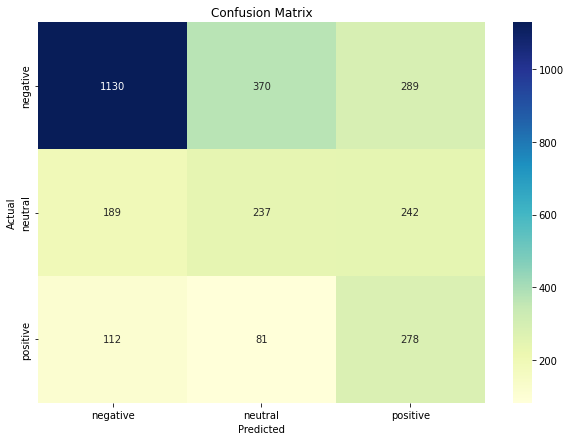

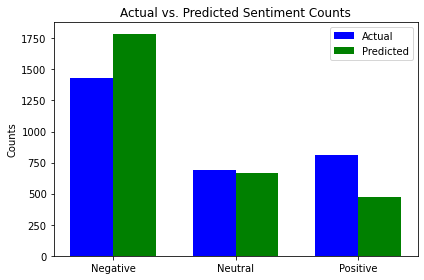

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the predictions data
data = pd.read_csv("predictions.csv")

# Create a confusion matrix
cm = confusion_matrix(data["true_label"], data["prediction"])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Bar plot for actual vs. predicted counts
labels = ['Negative', 'Neutral', 'Positive']
actual_counts = np.bincount(data['prediction'])
predicted_counts = np.bincount(data['true_label'])

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, actual_counts, width, label='Actual', color='b')
rects2 = ax.bar(x + width / 2, predicted_counts, width, label='Predicted', color='g')

ax.set_ylabel('Counts')
ax.set_title('Actual vs. Predicted Sentiment Counts')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()


#### The below script is a work in progress. The above plots reflect the initial test of the basic transformer model. 

In [40]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer
import numpy as np

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, attention_mask=None):
        embedded = self.dropout(self.embedding(text))
        packed_output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)

def create_data_loader(df, tokenizer, max_len, batch_size):
    # Map the sentiment labels to integers
    sentiment_map = {"negative": 0, "neutral": 1, "positive": 2}
    df["airline_sentiment"] = df["airline_sentiment"].map(sentiment_map)

    sequences = tokenizer(df["text"].tolist(), padding=True, truncation=True, max_length=max_len, return_tensors="pt")
    dataset = TensorDataset(sequences["input_ids"], sequences["attention_mask"], torch.tensor(df["airline_sentiment"].values, dtype=torch.long))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    n_examples = len(data_loader.dataset)

    for input_ids, attention_mask, targets in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct_predictions.double() / n_examples, epoch_loss / len(data_loader)

def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    correct_predictions = 0
    n_examples = len(data_loader.dataset)

    with torch.no_grad():
        for input_ids, attention_mask, targets in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            targets = targets.to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            epoch_loss += loss.item()

    return correct_predictions.double() / n_examples, epoch_loss / len(data_loader)

def save_predictions(model, data_loader, device, output_path="predictions.csv"):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, targets in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.tolist())
            true_labels.extend(targets.tolist())

    df = pd.DataFrame({"prediction": predictions, "true_label": true_labels})
    df.to_csv(output_path, index=False)
    return df

# Load the data
df = pd.read_csv("preprocessed_tweets.csv")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128
BATCH_SIZE = 64

# Create the data loaders
data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(data_loader.dataset))
val_size = len(data_loader.dataset) - train_size
train_data, val_data = random_split(data_loader.dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# Set up the model and training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_matrix = torch.zeros((tokenizer.vocab_size, 128))
model = LSTMClassifier(embedding_dim=128, hidden_dim=256, output_dim=3, dropout=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
EPOCHS = 20

# Train the model
for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_acc, val_loss = evaluate(model, val_loader, loss_fn, device)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Evaluate the model and save predictions
predictions_df = save_predictions(model, val_loader, device, "predictions.csv")

# Print classification report
print(classification_report(predictions_df["true_label"], predictions_df["prediction"]))




Epoch 1/20
Train Loss: 0.9614 | Train Acc: 0.6219
Val Loss: 0.9329 | Val Acc: 0.6171
Epoch 2/20
Train Loss: 0.9153 | Train Acc: 0.6294
Val Loss: 0.9295 | Val Acc: 0.6171
Epoch 3/20
Train Loss: 0.9149 | Train Acc: 0.6294
Val Loss: 0.9303 | Val Acc: 0.6171
Epoch 4/20
Train Loss: 0.9148 | Train Acc: 0.6294
Val Loss: 0.9325 | Val Acc: 0.6171
Epoch 5/20
Train Loss: 0.9154 | Train Acc: 0.6294
Val Loss: 0.9298 | Val Acc: 0.6171
Epoch 6/20
Train Loss: 0.9153 | Train Acc: 0.6294
Val Loss: 0.9299 | Val Acc: 0.6171
Epoch 7/20
Train Loss: 0.9155 | Train Acc: 0.6294
Val Loss: 0.9301 | Val Acc: 0.6171
Epoch 8/20
Train Loss: 0.9148 | Train Acc: 0.6294
Val Loss: 0.9298 | Val Acc: 0.6171
Epoch 9/20
Train Loss: 0.9161 | Train Acc: 0.6294
Val Loss: 0.9295 | Val Acc: 0.6171
Epoch 10/20
Train Loss: 0.9145 | Train Acc: 0.6294
Val Loss: 0.9295 | Val Acc: 0.6171
Epoch 11/20
Train Loss: 0.9138 | Train Acc: 0.6294
Val Loss: 0.9340 | Val Acc: 0.6171
Epoch 12/20
Train Loss: 0.9145 | Train Acc: 0.6294
Val Loss: 0.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
